# FIND THE BEVERAGE BUSINESSES IN RICHMOND, VANCOUVER, & BURNABY

The objective of this project is to find how many (non-alcohol) beverage bussinesses are in Metro Vancouver. Also find beverage franchises who are successful and how many franchises are operated in these three cities.

In [1]:
import pandas as pd
import numpy as np
#from pygeocoder import Geocoder
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.extra.rate_limiter import RateLimiter
import folium
from plotnine import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Suppress Deprecation and Incorrect Usage Warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read the data / Business in Burnaby, Vancouver, Richmond
# These datasets were obtained from the open data website by Burnaby, Vancouver, and Richmond
burnaby = pd.read_csv('burnabyBusiness_Licences.csv')
vancouver = pd.read_csv('van_business_licences.csv')
richmond = pd.read_csv('Richmond_Based_Businesses.csv')
# port_moody = pd.read_csv('port_moody_business.csv')

In [3]:
# Explore Data
print(burnaby.shape,vancouver.shape,richmond.shape)

(10788, 36) (69934, 24) (11933, 9)


Vancouver has around ~ 70k of business regiestered in Vancouver. Richmond ~ 12k and Burnaby ~ 11k.  
Vancouver has 24 columns.  
Richmond has 10 columns. Richmond does not have latitude and longitude  
Burnaby has 36 columns.

In [4]:
# Let's look at the richmond data first
richmond.head(5)

,BusinessName,BusinessDescription,Address,Phone,Naics,NaicsDescription,BusinessType,FullTime,PartTime
0,#9 Restaurant,Restaurant,5300 No 3 Rd Unit 812 Richmond BC V6X 2X9,604-278-7700,722511,Full-service restaurants,Food Service Establishment,20.0,30.0
1,.Com Gold Hair Salon,Hair / Beauty Salon,4151 Hazelbridge Way Unit 1190 Richmond BC V6...,604-370-2964,812115,Beauty salons,NaN,6.0,4.0
2,.Com Private Hair Salon,Hair Salon,4000 No 3 Rd Unit 3350 Richmond BC V6X 0J8,604-285-6855,812115,Beauty salons,NaN,4.0,2.0
3,.Com Vanity Hair Salon,Hair Salon,6211 No 3 Rd Unit 120 Richmond BC V6Y OC2,604-232-5567,812115,Beauty salons,NaN,5.0,2.0
4,0696787 BC Ltd,motorcycle car storage holding dismantling par...,1060 Millcarch St Unit 115 Richmond BC V6V 2H4,604-837-2942,418110,Recyclable metal merchant wholesalers,Second-Hand Dealer,1.0,0.0


In [5]:
richmond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 9 columns):
BusinessName           11933 non-null object
BusinessDescription    11929 non-null object
Address                11888 non-null object
Phone                  11894 non-null object
Naics                  11932 non-null object
NaicsDescription       11932 non-null object
BusinessType           7344 non-null object
FullTime               11931 non-null float64
PartTime               11931 non-null float64
dtypes: float64(2), object(7)
memory usage: 839.2+ KB


In [6]:
# Let's look for nonalchohol beverge stores and include them to our data. Otherwise, let's exclude all these since we are only looking for beverage places/cafe.
richmondnoaddress = richmond[richmond['Address'].isnull()]
richmondnoaddress.head()
# index# 2294 Choco Coo Cafe Inc / index# 6915, Milkcow Cafe.  
# The reason they did not have addresses is because they are new places located in the same new building.

,BusinessName,BusinessDescription,Address,Phone,Naics,NaicsDescription,BusinessType,FullTime,PartTime
949,Audi of Richmond,"new and used vehicle sales, and vehicle clean ...",NaN,604-279-9663,441110,New car dealers,Automobile Dealer,50.0,0.0
991,Aviscar Inc,Office for U-drive business at the airport,NaN,604-606-2847,532111,Passenger car rental,Vehicle For Hire Office,5.0,0.0
2121,"CDS (Canadian Dry Storage, CDS Cold Storage, C...","Third Party Warehousing (Dry, Cooler Freezer ...",NaN,604-279-0960,493110,General warehousing and storage,NaN,23.0,0.0
2123,CDS Group,third party warehousing services for the stora...,NaN,604-279-0960,493110,General warehousing and storage,NaN,50.0,0.0
2125,CDS Transportation Services Ltd,Temperature controlled fright distribution/log...,NaN,604-279-0960,484110,"General freight trucking, local",NaN,28.0,2.0


In [7]:
# Add address to Choco Coo Cafe and Milkcow Cafe
richmondadd = richmond.iloc[[2294,6915],]
richmondadd['Address'].iloc[0] = "7488 Lansdowne Rd #135 Richmond"
richmondadd['Address'].iloc[1] = "105-5668 Hollybridge Way Richmond"
richmondadd

,BusinessName,BusinessDescription,Address,Phone,Naics,NaicsDescription,BusinessType,FullTime,PartTime
2294,Choco Coo Cafe Inc,"selling coffee, drinks and desserts (no kitchen)",7488 Lansdowne Rd #135 Richmond,604-285-6000,722511,Full-service restaurants,Food Service Establishment,4.0,4.0
6915,Milkcow Cafe,Dessert Restaurant,105-5668 Hollybridge Way Richmond,778-688-5189,722511,Full-service restaurants,Food Service Establishment,2.0,2.0


In [8]:
# Find business that does not have address and exclude them if they are not beverage/cafe place 
#because str.contains method does not work if there are any NaN values in the row
richmond = richmond[richmond['Address'].notnull()]
richmond.isnull().sum()

BusinessName              0
BusinessDescription       4
Address                   0
Phone                    38
Naics                     0
NaicsDescription          0
BusinessType           4572
FullTime                  1
PartTime                  1
dtype: int64

In [9]:
#Extract addresses that have Unit number. This is so we can use the geocode to extract latitude and longitude from the address
richmond_unit = richmond[richmond['Address'].str.contains(r"[Uu]nit")]

In [10]:
#Extract addresses that have do not Unit number
richmond_no_unit = richmond[~richmond['Address'].str.contains(r"[Uu]nit")]

In [11]:
# Extract the street name and exclude the unit number. Geocode that I am using does not support unit number.
richmond_unit['Address'] = richmond_unit['Address'].str.extract(r"(\w.+)(?= Unit)")
richmond_unit.head()

,BusinessName,BusinessDescription,Address,Phone,Naics,NaicsDescription,BusinessType,FullTime,PartTime
0,#9 Restaurant,Restaurant,5300 No 3 Rd,604-278-7700,722511,Full-service restaurants,Food Service Establishment,20.0,30.0
1,.Com Gold Hair Salon,Hair / Beauty Salon,4151 Hazelbridge Way,604-370-2964,812115,Beauty salons,NaN,6.0,4.0
2,.Com Private Hair Salon,Hair Salon,4000 No 3 Rd,604-285-6855,812115,Beauty salons,NaN,4.0,2.0
3,.Com Vanity Hair Salon,Hair Salon,6211 No 3 Rd,604-232-5567,812115,Beauty salons,NaN,5.0,2.0
4,0696787 BC Ltd,motorcycle car storage holding dismantling par...,1060 Millcarch St,604-837-2942,418110,Recyclable metal merchant wholesalers,Second-Hand Dealer,1.0,0.0


In [12]:
# Add back the city to the address
richmond_unit["Address"] = richmond_unit["Address"] + " Richmond Canada"

In [13]:
# Check if Rich was added correctly 
richmond_unit.head()

,BusinessName,BusinessDescription,Address,Phone,Naics,NaicsDescription,BusinessType,FullTime,PartTime
0,#9 Restaurant,Restaurant,5300 No 3 Rd Richmond Canada,604-278-7700,722511,Full-service restaurants,Food Service Establishment,20.0,30.0
1,.Com Gold Hair Salon,Hair / Beauty Salon,4151 Hazelbridge Way Richmond Canada,604-370-2964,812115,Beauty salons,NaN,6.0,4.0
2,.Com Private Hair Salon,Hair Salon,4000 No 3 Rd Richmond Canada,604-285-6855,812115,Beauty salons,NaN,4.0,2.0
3,.Com Vanity Hair Salon,Hair Salon,6211 No 3 Rd Richmond Canada,604-232-5567,812115,Beauty salons,NaN,5.0,2.0
4,0696787 BC Ltd,motorcycle car storage holding dismantling par...,1060 Millcarch St Richmond Canada,604-837-2942,418110,Recyclable metal merchant wholesalers,Second-Hand Dealer,1.0,0.0


In [14]:
# Now for the address that did not have unit number. we still need to extract the street name and the city name. Exclude postal code and province
richmond_no_unit['Address'] = richmond_no_unit['Address'].str.extract(r"(\w.+)(?= BC)")

In [15]:
# Combine unit & no unit rows together
richmond = pd.concat([richmond_unit, richmond_no_unit])

In [16]:
#Check if there are any errors. No error
richmond.head()

,BusinessName,BusinessDescription,Address,Phone,Naics,NaicsDescription,BusinessType,FullTime,PartTime
0,#9 Restaurant,Restaurant,5300 No 3 Rd Richmond Canada,604-278-7700,722511,Full-service restaurants,Food Service Establishment,20.0,30.0
1,.Com Gold Hair Salon,Hair / Beauty Salon,4151 Hazelbridge Way Richmond Canada,604-370-2964,812115,Beauty salons,NaN,6.0,4.0
2,.Com Private Hair Salon,Hair Salon,4000 No 3 Rd Richmond Canada,604-285-6855,812115,Beauty salons,NaN,4.0,2.0
3,.Com Vanity Hair Salon,Hair Salon,6211 No 3 Rd Richmond Canada,604-232-5567,812115,Beauty salons,NaN,5.0,2.0
4,0696787 BC Ltd,motorcycle car storage holding dismantling par...,1060 Millcarch St Richmond Canada,604-837-2942,418110,Recyclable metal merchant wholesalers,Second-Hand Dealer,1.0,0.0


In [17]:
#richmond.loc[948,'Latitude']

Below codes extract latitude and longitude from the address.   
However, due to usage policy with the large number of data, Nominatim blocked me from extracting the latitude and longitude.    
Nominatim has usuage policy for 1 request per second. Even I set the time delay, due to a large number of data, it won't extract.   
Since we are only looking for the cafe/ non-alchohol beverage places, let's filter this first and find the locations after


In [18]:
# Format Address + City will give you the latitude and longitude with the "myGeocode"

# richmond['Latitude'] = None
# richmond['Longitude'] = None
# locator = Nominatim(user_agent="myGeocoder")
# geocode = RateLimiter(locator.geocode, min_delay_seconds = 2)  
# for i in range(len(richmond)):
#     try:
#         location = locator.geocode(richmond.loc[i,'Address'], timeout = 3)
#         richmond.loc[i,'Latitude'] = location.latitude   
#         richmond.loc[i,'Longitude'] = location.longitude
#     except GeocoderTimedOut as e:
#         print("Error: geocode failed on input %s with message %s"%(richmond.loc['Address'],e.message))
# print(richmond.head()) 



In [19]:
richmond[["BusinessName","BusinessDescription","NaicsDescription","BusinessType"]].head()

,BusinessName,BusinessDescription,NaicsDescription,BusinessType
0,#9 Restaurant,Restaurant,Full-service restaurants,Food Service Establishment
1,.Com Gold Hair Salon,Hair / Beauty Salon,Beauty salons,NaN
2,.Com Private Hair Salon,Hair Salon,Beauty salons,NaN
3,.Com Vanity Hair Salon,Hair Salon,Beauty salons,NaN
4,0696787 BC Ltd,motorcycle car storage holding dismantling par...,Recyclable metal merchant wholesalers,Second-Hand Dealer


In [20]:
# Find all the starbucks
richmond_starbucks = richmond[richmond["BusinessName"].str.lower().str.contains("starbucks")]

In [21]:
# Find the bubble tea place
richmond_bubble1 = richmond[richmond["BusinessName"].str.lower().str.contains("bubble")]

In [22]:
# Business Description columns had 4 Nan values. Checked they are not beverage place. Exclude from the list
richmond = richmond[richmond['BusinessDescription'].notnull()]
richmond.isnull().sum()

BusinessName              0
BusinessDescription       0
Address                   1
Phone                    37
Naics                     0
NaicsDescription          0
BusinessType           4572
FullTime                  1
PartTime                  1
dtype: int64

In [23]:
# Find the bubble tea place under "BusinessDescription" column
richmond_bubble2 = richmond[richmond["BusinessDescription"].str.lower().str.contains("bubble")]

In [24]:
# Find any other coffee places
richmond_coffee = richmond[richmond["BusinessDescription"].str.lower().str.contains("coffee")]

In [25]:
# Find cafe
richmond_cafe = richmond[richmond["BusinessName"].str.lower().str.contains("cafe")]

In [26]:
#Find juice bar
richmond_juice1 = richmond[richmond["BusinessName"].str.lower().str.contains("juice")]

In [27]:
# Find juice bar under "BusinessDescription" column
richmond_juice2 = richmond[richmond["BusinessDescription"].str.lower().str.contains("juice")]

In [28]:
# Combine all the beverage/cafe locations
richmond_nonalcohol_drinks = pd.concat([richmond_starbucks,richmond_bubble1,richmond_bubble2, richmond_coffee, richmond_cafe, richmond_juice1, richmond_juice2])
richmond_nonalcohol_drinks.shape

(297, 9)

In [29]:
# Remove all the duplicates
richmond_removed_duplicates = richmond_nonalcohol_drinks.drop_duplicates(subset='Address',keep = "first").reset_index().drop(columns='index')

In [30]:
# After removing duplicates, we have 154 rows instead of 297 rows.
richmond_removed_duplicates.shape

(154, 9)

In [31]:
richmond_removed_duplicates.head()

,BusinessName,BusinessDescription,Address,Phone,Naics,NaicsDescription,BusinessType,FullTime,PartTime
0,Starbucks Coffee #178,Coffee Retail Store,8100 No 2 Rd Richmond Canada,604-241-7842,445299,All other specialty food stores,Retail Trading,10.0,12.0
1,Starbucks Coffee #4426,Refreshment stand - coffee & related products,6551 No 3 Rd Richmond Canada,206-318-8705,722512,Limited-service eating places,"Food Service Establishment, Take-Out",5.0,10.0
2,Starbucks Coffee #4429,"Retailing coffee drinks, snacks & coffee acces...",11686 Steveston Hwy Richmond Canada,604-241-5900,722512,Limited-service eating places,"Food Service Establishment, Take-Out",5.0,10.0
3,Starbucks Coffee #4687,Coffee shop,4011 Bayview St Richmond Canada,604-204-0288,722511,Full-service restaurants,Food Service Establishment,4.0,10.0
4,Starbucks Coffee #47572,Retail cafe selling coffee and related products,4720 McClelland Rd Richmond Canada,206-318-4994,722512,Limited-service eating places,Food Service Establishment,5.0,15.0


In [32]:
# Adjust addresses
richmond_removed_duplicates.loc[55,'Address'] = "6060 Minoru Blvd Richmond Canada"
richmond_removed_duplicates.loc[58,'Address'] = "8311 Lansdowne Rd Richmond Canada"
richmond_removed_duplicates.loc[123,'Address'] = "6551 No 3 Rd Richmond Canada"

In [33]:
richmond_removed_duplicates.head()
#richmond_removed_duplicates.drop(richmond_removed_duplicates.index[55], inplace = True)

,BusinessName,BusinessDescription,Address,Phone,Naics,NaicsDescription,BusinessType,FullTime,PartTime
0,Starbucks Coffee #178,Coffee Retail Store,8100 No 2 Rd Richmond Canada,604-241-7842,445299,All other specialty food stores,Retail Trading,10.0,12.0
1,Starbucks Coffee #4426,Refreshment stand - coffee & related products,6551 No 3 Rd Richmond Canada,206-318-8705,722512,Limited-service eating places,"Food Service Establishment, Take-Out",5.0,10.0
2,Starbucks Coffee #4429,"Retailing coffee drinks, snacks & coffee acces...",11686 Steveston Hwy Richmond Canada,604-241-5900,722512,Limited-service eating places,"Food Service Establishment, Take-Out",5.0,10.0
3,Starbucks Coffee #4687,Coffee shop,4011 Bayview St Richmond Canada,604-204-0288,722511,Full-service restaurants,Food Service Establishment,4.0,10.0
4,Starbucks Coffee #47572,Retail cafe selling coffee and related products,4720 McClelland Rd Richmond Canada,206-318-4994,722512,Limited-service eating places,Food Service Establishment,5.0,15.0


In [34]:
#Now let's obtain the the latitude and longitude
richmond_removed_duplicates['Latitude'] = None
richmond_removed_duplicates['Longitude'] = None
locator = Nominatim(user_agent="myGeocoder")
geocode = RateLimiter(locator.geocode, min_delay_seconds = 2)  
for i in range(len(richmond_removed_duplicates)):
    location = locator.geocode(richmond_removed_duplicates.loc[i,'Address'], timeout = 3)
    richmond_removed_duplicates.loc[i,'Latitude'] = location.latitude   
    richmond_removed_duplicates.loc[i,'Longitude'] = location.longitude


In [35]:
# Successfully obtained the latitude and longitude
print(richmond_removed_duplicates.head(),richmond_removed_duplicates.tail()) 
richmond_total2 = richmond_removed_duplicates

              BusinessName                                BusinessDescription  \
0    Starbucks Coffee #178                                Coffee Retail Store   
1   Starbucks Coffee #4426      Refreshment stand - coffee & related products   
2   Starbucks Coffee #4429  Retailing coffee drinks, snacks & coffee acces...   
3   Starbucks Coffee #4687                                        Coffee shop   
4  Starbucks Coffee #47572    Retail cafe selling coffee and related products   

                               Address         Phone   Naics  \
0         8100 No 2 Rd Richmond Canada  604-241-7842  445299   
1         6551 No 3 Rd Richmond Canada  206-318-8705  722512   
2  11686 Steveston Hwy Richmond Canada  604-241-5900  722512   
3      4011 Bayview St Richmond Canada  604-204-0288  722511   
4   4720 McClelland Rd Richmond Canada  206-318-4994  722512   

                  NaicsDescription                          BusinessType  \
0  All other specialty food stores                  

# Let's look at Vancouver Data

In [36]:
vancouver.head()
# There are some businesses in the data that do not belong for Vancouver location

,LicenceRSN,LicenceNumber,LicenceRevisionNumber,BusinessName,BusinessTradeName,Status,IssuedDate,ExpiredDate,BusinessType,BusinessSubType,Unit,UnitType,House,Street,City,Province,Country,PostalCode,LocalArea,NumberOfEmployees,Latitude,Longitude,FeePaid,ExtractDate
0,3193480,19-100365,0,ESS Environmental Ltd,NaN,Cancelled,NaN,NaN,Personal Services,Inspection/Testing,NaN,NaN,NaN,NaN,Richmond,BC,CAN,NaN,NaN,1.0,NaN,NaN,NaN,2019-11-16
1,3219860,19-100393,0,Lift & Co,NaN,Issued,2018-11-22 10:07:13,NaN,Exhibitions/Shows/Concerts,Other,NaN,NaN,37,Bulwer St,Toronto,ON,CAN,M5T 1A1,02-Central Business/Downtown,0.0,NaN,NaN,331.0,2019-11-16
2,3221566,19-100394,0,Canada Green Building Council,NaN,Issued,2018-11-28 16:06:36,NaN,Exhibitions/Shows/Concerts,Other,202,Unit,47,Clarence St,Ottawa,ON,CAN,K1N 9K1,02-Central Business/Downtown,0.0,NaN,NaN,331.0,2019-11-16
3,3225267,19-100397,0,NaN,NaN,Cancelled,NaN,NaN,Office,Administration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2019-11-16
4,3226250,19-100762,0,Ronald V Simmer (Ronald Simmer),NaN,Pending,NaN,NaN,Artist,NaN,NaN,NaN,NaN,NaN,Burnaby,BC,CAN,NaN,NaN,1.0,NaN,NaN,NaN,2019-11-16


In [37]:
vancouver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69934 entries, 0 to 69933
Data columns (total 24 columns):
LicenceRSN               69934 non-null int64
LicenceNumber            69934 non-null object
LicenceRevisionNumber    69934 non-null int64
BusinessName             63879 non-null object
BusinessTradeName        26169 non-null object
Status                   69934 non-null object
IssuedDate               57583 non-null object
ExpiredDate              57586 non-null object
BusinessType             69934 non-null object
BusinessSubType          35401 non-null object
Unit                     18920 non-null object
UnitType                 18914 non-null object
House                    37673 non-null object
Street                   37674 non-null object
City                     69856 non-null object
Province                 69849 non-null object
Country                  69861 non-null object
PostalCode               37329 non-null object
LocalArea                62457 non-null object


In [38]:
vancouver.columns

Index(['LicenceRSN', 'LicenceNumber', 'LicenceRevisionNumber', 'BusinessName',
       'BusinessTradeName', 'Status', 'IssuedDate', 'ExpiredDate',
       'BusinessType', 'BusinessSubType', 'Unit', 'UnitType', 'House',
       'Street', 'City', 'Province', 'Country', 'PostalCode', 'LocalArea',
       'NumberOfEmployees', 'Latitude', 'Longitude', 'FeePaid', 'ExtractDate'],
      dtype='object')

In [39]:
# Extract only the columns I'm interest in
vancouver = vancouver[['BusinessName','BusinessTradeName','Status','BusinessType','BusinessSubType', 'House','Street','City','Province','NumberOfEmployees', 'Latitude','Longitude']]

In [40]:
vancouverBC = vancouver[vancouver['Province'].isin(['BC'])]

In [41]:
vancouverBC.head()
# Filter only data that were issued with business liscense

,BusinessName,BusinessTradeName,Status,BusinessType,BusinessSubType,House,Street,City,Province,NumberOfEmployees,Latitude,Longitude
0,ESS Environmental Ltd,NaN,Cancelled,Personal Services,Inspection/Testing,NaN,NaN,Richmond,BC,1.0,NaN,NaN
4,Ronald V Simmer (Ronald Simmer),NaN,Pending,Artist,NaN,NaN,NaN,Burnaby,BC,1.0,NaN,NaN
6,Shaun Blane Bester (Shaun Bester),Von Bessa Construction,Gone Out of Business,Artist Live/Work Studio,NaN,NaN,NaN,North Vancouver,BC,0.0,NaN,NaN
7,Mauro Management Ltd,Chatelaine Apartments,Issued,Apartment House,NaN,905,Chilco St,van,BC,0.0,NaN,NaN
8,1915 Haro Holdings Ltd,NaN,Issued,Apartment House,NaN,1915,Haro St,Vancouver,BC,0.0,NaN,NaN


In [42]:
van_issued = vancouverBC[vancouverBC['Status'].isin(['Issued'])]

In [43]:
# There are also cities that are not in Vancouver. We will extract Vancouver only
van_issued.City.unique()

array(['van', ' Vancouver', 'Burnaby', 'Richmond', 'Delta', 'Surrey',
       'Port Moody', 'Coquitlam', 'Victoria ', 'North Vancouver',
       'Port Coquitlam', 'Langley', 'New Westminster', 'West Vancouver',
       'Maple Ridge', 'Abbotsford', 'Chilliwack', 'Anmore', 'Coldstream',
       'White Rock', 'Penticton', 'Mayne Island', 'Victoria',
       'Bowen Island', 'Mission', 'Ladner', 'Golden', 'Abbottsford',
       'Sqamish', 'Westbank', 'Kamloops', 'Nanaimo', 'Kelowna',
       'Qualicum Beach', 'Fort Langley', 'Gibson', 'Sechelt',
       'Aldergrove', 'Pitt Meadows', 'Squamish', 'Vernon', 'Merrit',
       'Lions Bay', 'Halfmoon Bay', 'Summerland', 'Squamish ',
       'Saanichton', 'Cultus Lake', 'DELTA', 'Gibsons', 'Duncan',
       'Salmon Arm', 'VANCOUVER', 'NEW WESTMINSTER', 'Sardis',
       'Cloverdale', 'Nanaimio', 'Garibaldi Highlands', 'Parksville',
       'Seshelt', 'Cumberland', 'Agassiz', 'Anmore ', 'Brackendale',
       'kamloops', 'West Kelowna', 'Madeira Park', 'Belcarra

In [44]:
van2_issued = van_issued[van_issued.City.isin(['van',' Vancouver','North Vancouver', 'VANCOUVER', 'vancouver', 'North vancouver' , 'Vancouver'])]

In [45]:
# van2_issued.BusinessType.unique()

In [46]:
van2_issued.isnull().sum()
# Why are there Businesses with no names?

BusinessName          4144
BusinessTradeName    31987
Status                   0
BusinessType             0
BusinessSubType      25916
House                19829
Street               19829
City                     0
Province                 0
NumberOfEmployees        0
Latitude             20461
Longitude            20461
dtype: int64

In [47]:
# Let's remove all the businessname with no names because there is no information other than "short-term rentals."
# This is probably airbnb license
van2_issued[van2_issued['BusinessName'].isnull()].head()

,BusinessName,BusinessTradeName,Status,BusinessType,BusinessSubType,House,Street,City,Province,NumberOfEmployees,Latitude,Longitude
11051,NaN,NaN,Issued,Short-Term Rental,NaN,NaN,NaN,Vancouver,BC,0.0,NaN,NaN
55231,NaN,NaN,Issued,Short-Term Rental,NaN,NaN,NaN,Vancouver,BC,0.0,NaN,NaN
55232,NaN,NaN,Issued,Short-Term Rental,NaN,NaN,NaN,Vancouver,BC,0.0,NaN,NaN
55234,NaN,NaN,Issued,Short-Term Rental,NaN,NaN,NaN,Vancouver,BC,0.0,NaN,NaN
55235,NaN,NaN,Issued,Short-Term Rental,NaN,NaN,NaN,Vancouver,BC,0.0,NaN,NaN


In [48]:
van_BN_notnull = van2_issued[van2_issued['BusinessName'].notnull()]

In [49]:
# remove all the businesses that do not have address
van_street_notnull = van_BN_notnull[van_BN_notnull['Street'].notnull()]

In [50]:
van_street_notnull.head()

,BusinessName,BusinessTradeName,Status,BusinessType,BusinessSubType,House,Street,City,Province,NumberOfEmployees,Latitude,Longitude
7,Mauro Management Ltd,Chatelaine Apartments,Issued,Apartment House,NaN,905,Chilco St,van,BC,0.0,NaN,NaN
8,1915 Haro Holdings Ltd,NaN,Issued,Apartment House,NaN,1915,Haro St,Vancouver,BC,0.0,NaN,NaN
89,Gamomo Creative Lab Inc,Gamomo Creative Lab,Issued,Computer Services,Animation,719,3rd West St,North Vancouver,BC,0.0,NaN,NaN
1684,Jeremy Kim Ming Wong (Jeremy Wong),J W Signworks,Issued,Contractor - Special Trades,Signs,1721,Londsale Ave,North Vancouver,BC,2.0,NaN,NaN
4107,McFarland Marceau Architects Ltd,NaN,Issued,Office,Architect,15B,Chesterfield Place,North Vancouver,BC,12.0,NaN,NaN


In [51]:
#do not add van_bubble to concatenate
van_bubble = van_street_notnull[van_street_notnull["BusinessName"].str.lower().str.contains("bubble")].reset_index().drop(columns='index')
van_bubble2 = van_bubble.drop(van_bubble.index[0]).reset_index().drop(columns='index')

In [52]:
van_sb = van_street_notnull[van_street_notnull["BusinessName"].str.lower().str.contains("starbuck")].reset_index().drop(columns='index')

In [53]:
van_coffee = van_street_notnull[van_street_notnull["BusinessName"].str.lower().str.contains("coffee")].reset_index().drop(columns='index')

In [54]:
#do not add van_cafe to concatenate
van_cafe = van_street_notnull[van_street_notnull["BusinessName"].str.lower().str.contains("cafe")].reset_index().drop(columns='index')
van_exclude_cactus = van_cafe[~van_cafe["BusinessName"].str.lower().str.contains("cactus")].reset_index().drop(columns='index')

In [55]:
#do not add
van_timhortons = van_street_notnull[van_street_notnull.BusinessTradeName.notnull()]

In [56]:
van_timhortons2 = van_timhortons[van_timhortons["BusinessTradeName"].str.lower().str.contains("horton")].reset_index().drop(columns='index')

In [57]:
van_coffee2 = van_timhortons[van_timhortons["BusinessTradeName"].str.lower().str.contains("coffee")].reset_index().drop(columns='index')

In [58]:
# do not add van_take
van_take = van_timhortons[van_timhortons["BusinessTradeName"].str.lower().str.contains("take")].reset_index().drop(columns='index')
van_take_5 = van_take.drop(van_take.index[[0,1,4]]).reset_index().drop(columns='index')

In [59]:
van_jjbean = van_timhortons[van_timhortons["BusinessTradeName"].str.lower().str.contains("jj bean")].reset_index().drop(columns='index')

In [60]:
van_bubble3 = van_timhortons[van_timhortons["BusinessTradeName"].str.lower().str.contains("bubble")].reset_index().drop(columns='index')

In [61]:
van_total = pd.concat([van_bubble2,van_sb,van_coffee,van_exclude_cactus,van_timhortons2,van_coffee2,van_take_5,van_jjbean,van_bubble3])

In [62]:
van_total2 = van_total.drop_duplicates(subset='Street',keep = "first").reset_index().drop(columns='index')

In [63]:
van_total2.shape

(132, 12)

In [64]:
# There is one missing latitude and longitude values in van_total2. Let's just add manually
van_total2.isnull().sum()

BusinessName          0
BusinessTradeName    21
Status                0
BusinessType          0
BusinessSubType      70
House                 0
Street                0
City                  0
Province              0
NumberOfEmployees     0
Latitude              1
Longitude             1
dtype: int64

In [65]:
#Let's just add manually
van_total2[van_total2.Latitude.isnull()]

,BusinessName,BusinessTradeName,Status,BusinessType,BusinessSubType,House,Street,City,Province,NumberOfEmployees,Latitude,Longitude
21,Starbucks Coffee Canada Inc,Starbucks Coffee,Issued,Ltd Service Food Establishment,NaN,1752,Commercial Dr,Vancouver,BC,0.0,NaN,NaN


In [66]:
van_total2['Latitude'].iloc[21] = 49.269130
van_total2['Longitude'].iloc[21] = -123.068997

In [67]:
# Group together 'House' + 'Street' + 'City' to create address for the locations
van_total2['Address'] = van_total2['House'].astype(str) + ' ' +van_total2['Street'] + ' ' + van_total2['City']
van_total2.head()

,BusinessName,BusinessTradeName,Status,BusinessType,BusinessSubType,House,Street,City,Province,NumberOfEmployees,Latitude,Longitude,Address
0,L & G Bubble Teahouse Ltd,L & G Bubble Teahouse,Issued,Ltd Service Food Establishment,NaN,5816,FRASER ST,Vancouver,BC,2.0,49.231768,-123.090208,5816 FRASER ST Vancouver
1,HL Bubble Tea House Ltd,Bubble World Tea House,Issued,Ltd Service Food Establishment,NaN,3377,KINGSWAY,Vancouver,BC,5.0,49.233038,-123.032942,3377 KINGSWAY Vancouver
2,Bubble Bee Bubble Tea House Ltd,Bubble Bee,Issued,Ltd Service Food Establishment,NaN,88,W PENDER ST,Vancouver,BC,1.0,49.280290,-123.106752,88 W PENDER ST Vancouver
3,Bubble Bear Cafe Inc,NaN,Issued,Ltd Service Food Establishment,NaN,8051,GRANVILLE ST,Vancouver,BC,2.0,49.212534,-123.140789,8051 GRANVILLE ST Vancouver
4,Viral Bubble Tea Shop Ltd,The Bubble Tea Shop,Issued,Ltd Service Food Establishment,NaN,1764,MANITOBA ST,Vancouver,BC,15.0,49.269549,-123.105817,1764 MANITOBA ST Vancouver


# Let's look at Burnaby Data

In [68]:
burnaby.head()

,X,Y,OBJECTID,BBY_PID,LOT_ID,GIS_ID,LTO_PID,ST_UNIT,ST_NMBR,ST_NAME,ST_TYPE,ST_SFX,UNIT,ADDRESS,PLAN,DL,BLOCK,LOT,STRATA,AIR_SPACE,AGGREGATE,AGGR_ROLL,CASENO,STATUS,CASE_TYPE,PID,CASE_BUS_TR_NAME,CASE_BUS_TYPE_DESC,BUS_CLASS_UNITS,BUS_CLASS_NO,BUS_CLASS_DESC,APPLYDATE,ISSUEDATE,EXPIRYDATE,LICENCESTATUS,NAME_LAST
0,-123.018311,49.204485,1001,000-037-043,36144,39820,002-868-440,,8783,GREENALL,AVE,NaN,,8765 GREENALL AV,NWP1742,161,12,A,N,N,C,5265-8765-0000,BUS06-00179,Approved,NaN,000-037-043,GALA CUSTOM CABINETS,Cabinet installation,Persons,2.0,Contractor's Shop and Yard,2005-12-28T00:00:00.000Z,2018-12-04T00:00:29.000Z,2019-12-31T00:00:00.000Z,Approved,GALA CUSTOM CABINETS LTD
1,-122.958607,49.275394,1002,000-048-984,7841,10714,009-299-327,,990,CLIFF,AVE,NaN,,990 CLIFF AV,NWP24065,207,,30,N,N,N,NaN,BUS06-00182,Approved,NaN,000-048-984,MY FATHER'S GARDEN,Food & product marketing/food prep for craft f...,NaN,NaN,Home Based Business - General,2005-12-29T00:00:00.000Z,2018-12-28T13:35:31.000Z,2019-12-31T00:00:00.000Z,Approved,JANICE BOBIC
2,-122.946857,49.227693,1003,000-026-707,25770,30346,002-437-040,,7661,FORMBY,ST,NaN,,7661 FORMBY ST,NWP534,91,2,4,N,N,N,NaN,BUS06-00186,Approved,NaN,000-026-707,AUJLA DEVELOPMENT,Builder,NaN,NaN,Home Based Business - Contractor,2005-12-29T00:00:00.000Z,2018-12-31T15:50:52.000Z,2019-12-31T00:00:00.000Z,Approved,AUJLA DEVELOPMENT LTD
3,-123.022561,49.255627,1004,000-014-413,14977,23643,018-423-264,301,3738,NORFOLK,ST,NaN,301,3733 NORFOLK ST,LMS1035,69,,33,Y,N,N,NaN,BUS06-00222,Approved,NaN,000-014-488,AMIR J HIRANI & ASSOCIATES,Management Consulant,NaN,NaN,Home Based Business - General,2006-01-04T00:00:00.000Z,2018-11-03T00:00:31.000Z,2019-12-31T00:00:00.000Z,Approved,AMIR J HIRANI & ASSOCIATES INC
4,-122.943945,49.222206,1005,000-031-692,28927,17076,002-604-051,,7548,EDMONDS,ST,NaN,,7530 EDMONDS ST,NWP44876,30,,97,N,N,N,NaN,BUS06-00257,Approved,NaN,000-031-692,LITTLE COCKATOO CAFE RESTAURANT,42 seats + 8 outdoor patio,Seats,50.0,Restaurant,2006-01-09T00:00:00.000Z,2018-12-13T00:01:18.000Z,2019-12-31T00:00:00.000Z,Approved,MIHAJLO VRECA


In [69]:
burnaby2 = burnaby[['X','Y','ADDRESS','STATUS','CASE_BUS_TR_NAME','CASE_BUS_TYPE_DESC','BUS_CLASS_UNITS','BUS_CLASS_NO','BUS_CLASS_DESC','NAME_LAST']]

In [70]:
burnaby2.STATUS.unique()
# Burnaby data only includes business that are approved, which we do not have to filter by approved status

array(['Approved'], dtype=object)

In [71]:
burnaby2.isnull().sum()

X                        0
Y                        0
ADDRESS                  0
STATUS                   0
CASE_BUS_TR_NAME       350
CASE_BUS_TYPE_DESC      11
BUS_CLASS_UNITS       6667
BUS_CLASS_NO          6663
BUS_CLASS_DESC           0
NAME_LAST              949
dtype: int64

In [72]:
# There are no cafe/ beverage businesses in the below table. Thus, we will exclude business with no names
burnaby_name = burnaby2[burnaby2.CASE_BUS_TR_NAME.notnull()]

In [73]:
bby_bubble = burnaby_name[burnaby_name["CASE_BUS_TR_NAME"].str.lower().str.contains("bubble")].reset_index().drop(columns='index')
bby_bubble

,X,Y,ADDRESS,STATUS,CASE_BUS_TR_NAME,CASE_BUS_TYPE_DESC,BUS_CLASS_UNITS,BUS_CLASS_NO,BUS_CLASS_DESC,NAME_LAST
0,-123.008766,49.231009,4300 KINGSWAY,Approved,BUBBLE WORLD,Beverages & Snacks,Seats,50.0,Restaurant,641823 BC LTD
1,-122.918223,49.276449,8888 UNIVERSITY DR,Approved,BUBBLEWORLD,Take out,Seats,0.0,Restaurant,CLIENT CONNECTION INC
2,-123.004875,49.229104,4500 KINGSWAY,Approved,BUBBLE WAFFLE CAFE,Fish noodles & rice,Seats,0.0,Restaurant,XU YUEN CATERING CORP
3,-123.000239,49.268089,4567 LOUGHEED HY,Approved,BUBBLE WAFFLE,Fast food restaurant,Seats,0.0,Restaurant,1080078 BC LTD
4,-122.997848,49.225361,4800 KINGSWAY,Approved,BUBBLE WAFFLE CAFE,Chinese fast food,Seats,0.0,Restaurant,0947818 BC LTD


In [74]:
burnaby_desc = burnaby2[burnaby2.CASE_BUS_TYPE_DESC.notnull()]
bby_bubble2 = burnaby_desc[burnaby_desc["CASE_BUS_TYPE_DESC"].str.lower().str.contains("bubble")].reset_index().drop(columns='index')

In [75]:
bby_beverages = burnaby_desc[burnaby_desc["CASE_BUS_TYPE_DESC"].str.lower().str.contains("beverages")].reset_index().drop(columns='index')
bby_beverages2 = bby_beverages.drop(bby_beverages.index[0]).reset_index().drop(columns='index')

In [76]:
bby_coffee = burnaby_desc[burnaby_desc["CASE_BUS_TYPE_DESC"].str.lower().str.contains("coffee")].reset_index().drop(columns='index')

In [77]:
bby_cafe = burnaby_desc[burnaby_desc["CASE_BUS_TYPE_DESC"].str.lower().str.contains("cafe")].reset_index().drop(columns='index')
#check 66 rows if they are actually cafes we are searching for. I see that there are employee cafeteria registered under
# Vacnouver business license. Exclude this data

In [78]:
#[1,2,3,4,6,9,18,19,21,22,25,27,30,31,33,36,37,39,40,43,44,45,46,47,48,63,64]
#np.delete(bby_cafe, [[1,2,3,4,6,9,18,19,21,22,25,27,30,31,33,36,37,39,40,43,44,45,46,47,48,63,64]], axis=0)
bby_cafe = bby_cafe.drop(bby_cafe.index[1])

In [79]:
bby_total = pd.concat([bby_bubble,bby_bubble2,bby_beverages2,bby_coffee,bby_cafe])

In [80]:
# Remove all the duplicates
bby_total2 = bby_total.drop_duplicates(subset='ADDRESS',keep = "first").reset_index().drop(columns='index')

In [81]:
bby_total2['ADDRESS'] = bby_total2['ADDRESS'] + ' BURNABY'

In [82]:
bby_total2.head()

,X,Y,ADDRESS,STATUS,CASE_BUS_TR_NAME,CASE_BUS_TYPE_DESC,BUS_CLASS_UNITS,BUS_CLASS_NO,BUS_CLASS_DESC,NAME_LAST
0,-123.008766,49.231009,4300 KINGSWAY BURNABY,Approved,BUBBLE WORLD,Beverages & Snacks,Seats,50.0,Restaurant,641823 BC LTD
1,-122.918223,49.276449,8888 UNIVERSITY DR BURNABY,Approved,BUBBLEWORLD,Take out,Seats,0.0,Restaurant,CLIENT CONNECTION INC
2,-123.004875,49.229104,4500 KINGSWAY BURNABY,Approved,BUBBLE WAFFLE CAFE,Fish noodles & rice,Seats,0.0,Restaurant,XU YUEN CATERING CORP
3,-123.000239,49.268089,4567 LOUGHEED HY BURNABY,Approved,BUBBLE WAFFLE,Fast food restaurant,Seats,0.0,Restaurant,1080078 BC LTD
4,-122.997848,49.225361,4800 KINGSWAY BURNABY,Approved,BUBBLE WAFFLE CAFE,Chinese fast food,Seats,0.0,Restaurant,0947818 BC LTD


# Combine the dataset

In [83]:
# Combine VCR, RICHMOND, BURNABY dataset together
richmond_total2.head()
richmond_total2['City'] = 'Richmond'
richmond_total3 = richmond_total2[['BusinessName','Address', 'City','Latitude','Longitude']]
richmond_total3.head()

,BusinessName,Address,City,Latitude,Longitude
0,Starbucks Coffee #178,8100 No 2 Rd Richmond Canada,Richmond,49.1705,-123.159
1,Starbucks Coffee #4426,6551 No 3 Rd Richmond Canada,Richmond,49.1681,-123.137
2,Starbucks Coffee #4429,11686 Steveston Hwy Richmond Canada,Richmond,49.1325,-123.092
3,Starbucks Coffee #4687,4011 Bayview St Richmond Canada,Richmond,49.124,-123.181
4,Starbucks Coffee #47572,4720 McClelland Rd Richmond Canada,Richmond,49.1777,-123.121


In [84]:
van_total2.head()
van_total2['City'] = 'Vancouver'
van_total3 = van_total2[['BusinessName','Address','City','Latitude','Longitude']]
van_total3.head()

,BusinessName,Address,City,Latitude,Longitude
0,L & G Bubble Teahouse Ltd,5816 FRASER ST Vancouver,Vancouver,49.231768,-123.090208
1,HL Bubble Tea House Ltd,3377 KINGSWAY Vancouver,Vancouver,49.233038,-123.032942
2,Bubble Bee Bubble Tea House Ltd,88 W PENDER ST Vancouver,Vancouver,49.280290,-123.106752
3,Bubble Bear Cafe Inc,8051 GRANVILLE ST Vancouver,Vancouver,49.212534,-123.140789
4,Viral Bubble Tea Shop Ltd,1764 MANITOBA ST Vancouver,Vancouver,49.269549,-123.105817


In [85]:
bby_total2.head()
bby_total2['City'] = 'Burnaby'
bby_total2.rename({'Y':'Latitude','X':'Longitude', 'ADDRESS':'Address', 'CASE_BUS_TR_NAME':'BusinessName'}, axis = 1, inplace=True)
bby_total3 = bby_total2[['BusinessName','Address','City','Latitude','Longitude']]
bby_total3.head()

,BusinessName,Address,City,Latitude,Longitude
0,BUBBLE WORLD,4300 KINGSWAY BURNABY,Burnaby,49.231009,-123.008766
1,BUBBLEWORLD,8888 UNIVERSITY DR BURNABY,Burnaby,49.276449,-122.918223
2,BUBBLE WAFFLE CAFE,4500 KINGSWAY BURNABY,Burnaby,49.229104,-123.004875
3,BUBBLE WAFFLE,4567 LOUGHEED HY BURNABY,Burnaby,49.268089,-123.000239
4,BUBBLE WAFFLE CAFE,4800 KINGSWAY BURNABY,Burnaby,49.225361,-122.997848


In [86]:
van_rich_bby = pd.concat([richmond_total3,van_total3,bby_total3])

In [87]:
van_rich_bby = van_rich_bby.reset_index().drop(columns = 'index')

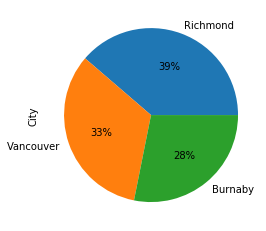

In [88]:
van_rich_bby['City'].value_counts().plot.pie(autopct='%1.0f%%')

In [89]:
van_rich_bby['City'].value_counts()

Richmond     154
Vancouver    132
Burnaby      112
Name: City, dtype: int64

Coffee shops/ non-alcohol beverages stores are 154 in Richmond ( 39% ), 132 in Vancouver ( 33% ), and 112 in Burnaby ( 28 %). But when we look at the ratio per 1000 stores for each cities, Richmond businesses (12.9 stores per 1000) have more beverage/ cafe busineesses compare to the other two cities (Van: 1.9 per 1000 and Burnaby: 0.8 per 1000).

#      To compare more concisely, the ratio per 1000 stores are the followings:  
Richmond: 12.9 stores per 1000 business  
Vancouver: 1.9 stores per 1000 business  
Burnaby: 0.8 stores per 1000 business

In [90]:
Vanratio = round((richmond_total3.shape[0]/len(richmond) *100),2)

In [91]:
Bbyratio = round((van_total3.shape[0]/len(vancouver) *100),2)

In [92]:
Richratio = round((bby_total3.shape[0]/len(burnaby) *100),2)

# Let's look at where they are

In [93]:
van_rich_bby.Latitude = van_rich_bby.Latitude.astype(float)
van_rich_bby.Longitude = van_rich_bby.Longitude.astype(float)
van_rich_bby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 5 columns):
BusinessName    398 non-null object
Address         398 non-null object
City            398 non-null object
Latitude        398 non-null float64
Longitude       398 non-null float64
dtypes: float64(2), object(3)
memory usage: 15.7+ KB


In [95]:
geo_df = van_rich_bby.copy()
geo_df.head()

,BusinessName,Address,City,Latitude,Longitude
0,Starbucks Coffee #178,8100 No 2 Rd Richmond Canada,Richmond,49.170535,-123.158901
1,Starbucks Coffee #4426,6551 No 3 Rd Richmond Canada,Richmond,49.168133,-123.137205
2,Starbucks Coffee #4429,11686 Steveston Hwy Richmond Canada,Richmond,49.132524,-123.092490
3,Starbucks Coffee #4687,4011 Bayview St Richmond Canada,Richmond,49.124010,-123.180893
4,Starbucks Coffee #47572,4720 McClelland Rd Richmond Canada,Richmond,49.177748,-123.121130


In [96]:
geo_df['BusinessName'][0]

'Starbucks Coffee #178'

Let's see how they are distributed out around Metro Vancouver area using folium map package

In [98]:
map = folium.Map(location=[geo_df['Latitude'].mean(), geo_df['Longitude'].mean()], zoom_start=10)

for n in geo_df.index:
    # This is what will be seen on the marker pop up box
    popup_name = geo_df['BusinessName'][n] + geo_df['Address'][n] 
    # Different color for three cities
    if geo_df.loc[n,'City'] == 'Richmond' :
        icon_color = 'pink'
    elif geo_df.loc[n,'City'] == 'Vancouver':
        icon_color = 'green'
    else:
        icon_color = 'blue'    
    folium.map.Marker(
        location = [geo_df.loc[n, 'Latitude'], geo_df.loc[n, 'Longitude']],
        popup= folium.Popup(popup_name, parse_html=True),
        icon=folium.Icon(color=icon_color),
     ).add_to(map)
    

map
#.save('C:/Users/munsu/dataquest/python/van_rich_bby.html')

Vancouver beverage stores are mostly clustered in the downtown.  
Burnaby stores are mostly clusterd with either beside big malls and new developed area (new high rises).  
Richmond stores are mostly clustered on No 3 Road. This is where all the restaruants and malls are.

In [ ]:
# https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Popups.ipynb
#Parse 

Now we seen where they are, let's group them by the franchise. If not a franchise, we will group them under 'Coffee,Bakery,IceCream' shops.

In [ ]:
van_rich_bby.loc[van_rich_bby.BusinessName.str.contains('Bubble|BUBBLE|CHATIME|ZENQ|BUBBLEWORLD|PLUM|COCO'),'Type'] = 'BubbleTea'

In [ ]:
van_rich_bby.loc[van_rich_bby.BusinessName.str.lower().str.contains('starbucks'),'Type'] = 'Starbucks'

In [ ]:
van_rich_bby.loc[van_rich_bby.BusinessName.str.lower().str.contains('bean'),'Type'] = 'JJ bean'

In [ ]:
van_rich_bby.loc[van_rich_bby.BusinessName.str.lower().str.contains('horton'),'Type'] = 'Tim Hortons'

In [ ]:
van_rich_bby.Type = van_rich_bby.Type.fillna('Coffee,Bakery,IceCream')

In [ ]:
van_rich_bby.head()

In [ ]:
geo_df = van_rich_bby.copy()
geo_df.Type.value_counts()

In [ ]:
map = folium.Map(location=[geo_df['Latitude'].mean(), geo_df['Longitude'].mean()], zoom_start=10)

folium.Popup(popup_name, parse_html=True)
for n in geo_df.index:
    # This is what will be seen on the marker pop up box
    popup_name = geo_df['BusinessName'][n] + geo_df['Address'][n] + ' - ' + geo_df['Type'][n]
    # Different color for three cities
    if geo_df.loc[n,'Type'] == 'Coffee,Bakery,IceCream' :
        icon_color = 'black'
    elif geo_df.loc[n,'Type'] == 'Starbucks':
        icon_color = 'green'
    else:
        icon_color = 'red'    
    folium.map.Marker(
        location = [geo_df.loc[n, 'Latitude'], geo_df.loc[n, 'Longitude']],
        popup= folium.Popup(popup_name,parse_html=True),
        icon=folium.Icon(color=icon_color),
     ).add_to(map)
    

map

In [ ]:
van_rich_bby['Type'].value_counts()

In [ ]:
van_rich_bby['Type'].value_counts().plot.pie(autopct='%1.0f%%')

There are 21% of starbucks( N = 83 ) out of all the beverage places in Vancouver, Burnaby, and Richmond. Looking at the data, most of shops are operated by non-franchise owners. A couple of franchises are bubble world, starbucks, tim hortons, waves, and jj bean. There definietely more than 3 Tim hortons in Vancouver, Richmond and Burnaby. The reason it did not extract from the business license datasets is they are under a different name.

In [ ]:
van_rich_bby.groupby(['City','Type']).size()

Out of 83 starbucks, 55 are operated in Vancouver. On the other hand 126 stores (out of 276) that are mostly owned by non-franchise owners are in Richmond. This stores mostly sells Asian beverages and there is a big Chineses community in Richmond.

In summary, there are 83 starbucks in Vancouver, Burnaby, and Richmond, where starbucks dominated the coffee/beverage market as a franchise. Starbucks located in Vancouver is 41.7% (N=55). On the other hand, Richmond and burnaby are dominated by non-franchise stores: 81.8% and 78.6% respectively. Starbucks percentages in these two cities are respectively, 10.4% (N=16) and 10.7% (N=12).